In [63]:
#Referencia : Codigo brindado en clase
#Integrantes : Bryann Alfaro, Raul Jimenez, Donaldo Garcia

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.utils import load_dataset

import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tf.compat.v1.disable_eager_execution()

In [65]:
#Load the model 
model1 = tf.keras.models.load_model('modelo_lab')

In [66]:
# crea un dataframe a partir de las carpetas dentro de "malimg_dataset" y sus archivos .bytes
df = pd.DataFrame(columns=['Family', 'Image'])
fam_cat = {}
for i, family in enumerate(os.listdir('malimg_dataset')):
    fam_cat[i] = family
    for image in os.listdir(f'malimg_dataset/{family}'):
        imagen = Image.open(f'malimg_dataset/{family}/{image}')
        imagen = imagen.resize((64,64))
        new_data = {'Family': [family], 'Name': [image], 'Family_cat': [i], 'Image': [np.array(imagen).tolist()]}
        new_df = pd.DataFrame(new_data)
        df = pd.concat([df, new_df], ignore_index=True)
# muestra las primeras 5 filas del dataframe
df.head()

,Family,Image,Name,Family_cat
0,Adialer.C,"[[2, 3, 0, 7, 1, 1, 0, 2, 12, 13, 15, 9, 12, 1...",000bde2e9a94ba41c0c111ffd80647c2.png,0.0
1,Adialer.C,"[[2, 14, 2, 0, 0, 0, 4, 4, 11, 6, 12, 20, 9, 1...",000e30a0819ac7ed931d629ce2ef8948.png,0.0
2,Adialer.C,"[[2, 14, 2, 0, 0, 0, 5, 6, 11, 6, 12, 20, 9, 1...",002f06eff1d222560939be72583d6ae9.png,0.0
3,Adialer.C,"[[2, 3, 0, 6, 1, 0, 0, 2, 13, 13, 15, 9, 12, 1...",0044f0746b812f6b454ce210bc58c572.png,0.0
4,Adialer.C,"[[2, 3, 0, 6, 1, 0, 0, 2, 12, 13, 15, 9, 12, 1...",0046a83d932a3d431eb21a99b46d6af7.png,0.0


In [67]:
# removemos las familias con menos de 150 muestras del dataset
df = df[df['Family'].isin(df['Family'].value_counts()[df['Family'].value_counts() > 150].index)]
df.value_counts('Family')

Family
Allaple.A         2949
Allaple.L         1591
Yuner.A            800
Instantaccess      431
VB.AT              408
Fakerean           381
Lolyda.AA1         213
C2LOP.gen!g        200
Alueron.gen!J      198
Lolyda.AA2         184
Dialplatform.B     177
Dontovo.A          162
Lolyda.AT          159
Rbot!gen           158
dtype: int64

In [68]:
# use on the the last 20% of the dataset
df = df.iloc[int(len(df)*0.8):]

In [69]:
#Dividir el dataset
from sklearn.model_selection import train_test_split
X = df['Image'].values
y = df['Family_cat'].values
#convert X to numpy array and inside with simple list
X = np.array([np.array(xi) for xi in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Normalizar los datos
X_train

array([[[ 91,  88,  95, ...,  93, 110,  92],
        [ 97, 110,  99, ..., 105, 101,  93],
        [114,  96,  93, ..., 108, 101,  98],
        ...,
        [108, 104,  57, ...,  85,  91,  97],
        [ 65,  60,  73, ...,  60,  56,  59],
        [137, 126, 127, ..., 123, 128, 126]],

       [[ 41,  35,  28, ...,  26,  37,  38],
        [ 15,  14,  12, ...,   7,  10,  11],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [144, 167, 165, ..., 143, 161, 159],
        [ 98, 113, 112, ..., 110, 119,  93],
        [ 65,  64,  68, ...,  68,  72,  68]],

       [[ 41,  35,  28, ...,  26,  37,  38],
        [ 15,  14,  12, ...,   7,  11,  11],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [ 94,  97,  97, ..., 103,  92,  87],
        [ 48,  49,  45, ...,  52,  43,  47],
        [ 20,  25,  29, ...,  28,  28,  24]],

       ...,

       [[ 91,  88,  95, ...,  93, 110,  92],
        [ 97, 110,  99, ..., 105, 101,  93],
        [114,  96,  93, ..., 108, 101,  98

In [70]:
#Normalizar los datos
X_train = X_train/255
X_test = X_test/255

0.9333333333333333

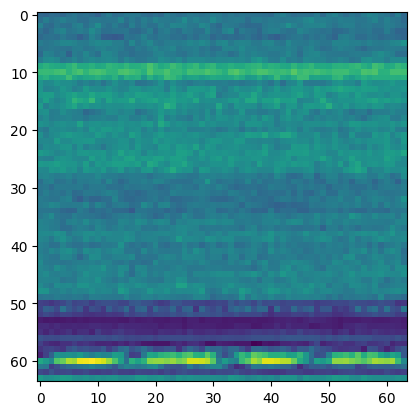

In [71]:
#Mostrar una imagen
plt.imshow(X_train[0])
#mostrar la normalizacion
X_train[0].max()

In [72]:
print(X_train.shape, X_test.shape)

(1282, 64, 64) (321, 64, 64)


In [73]:
X_train = X_train.reshape(1282, 64, 64, 1)
X_test = X_test.reshape(321, 64, 64, 1)

In [74]:
from tensorflow.keras.utils import to_categorical
categorical_y_entrenamiento = to_categorical(y_train, 25)
categorical_y_test = to_categorical(y_test, 25)

# Ataque de extraccion

In [77]:
clasificador = KerasClassifier(
    model=model1,
    clip_values=(0.0, 1.0))

In [78]:
from art.attacks.extraction import CopycatCNN
# Creating the "neural net thief" object
# that will steal the original classifier
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador
    )

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
modelo_stole = Sequential()
modelo_stole.add(Conv2D(filters = 32, kernel_size = (4, 4), input_shape = (64, 64, 1), activation = 'relu'))
modelo_stole.add(MaxPool2D(pool_size = (2, 2)))
modelo_stole.add(Flatten())
modelo_stole.add(Dense(128, activation = 'relu'))
modelo_stole.add(Dense(25, activation = 'softmax'))
modelo_stole.compile(loss = 'categorical_crossentropy',optimizer = 'rmsprop',metrics = ['accuracy'])

model_stolen = KerasClassifier(
    model=modelo_stole, 
    clip_values=(0.0,1.0)
    )

In [82]:
# Extracting a thieved classifier
# by training the reference model
stolen_classifier = copycat_cnn.extract(
    x=X_train, 
    y=y_train, 
    thieved_classifier=model_stolen
    )

c:\Users\raula\Documents\RAUL_ANGEL\UVG_COMPU\NOVENO_SEMESTRE\SECURITY-DATA-SCIENCE\venv\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 1282 samples
Epoch 1/20
1282/1282 [==============================] - 1s 1000us/sample - loss: 3.9929 - accuracy: 0.3144
Epoch 2/20
1282/1282 [==============================] - 1s 945us/sample - loss: 0.7513 - accuracy: 0.6677
Epoch 3/20
1282/1282 [==============================] - 1s 920us/sample - loss: 0.5022 - accuracy: 0.8549
Epoch 4/20
1282/1282 [==============================] - 1s 973us/sample - loss: 0.4113 - accuracy: 0.8619
Epoch 5/20
1282/1282 [==============================] - 1s 974us/sample - loss: 0.6957 - accuracy: 0.8089
Epoch 6/20
1282/1282 [==============================] - 1s 941us/sample - loss: 0.3774 - accuracy: 0.8760
Epoch 7/20
1282/1282 [==============================] - 1s 895us/sample - loss: 0.2674 - accuracy: 0.9181
Epoch 8/20
1282/1282 [==============================] - 1s 889us/sample - loss: 0.8866 - accuracy: 0.7816
Epoch 9/20
1282/1282 [==============================] - 1s 895us/sample - loss: 0.2483 - accuracy: 0.9329
Epoch 10/20
1282/1282 [

In [84]:
# Testing the performance of the original classifier
score_original = clasificador._model.evaluate(
    x=X_test, 
    y=categorical_y_test
    )

# Testing the performance of the stolen classifier
score_stolen = stolen_classifier._model.evaluate(
    x=X_test, 
    y=categorical_y_test
    )

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} " 
      f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} " 
      f"vs stolen test accuracy: {score_stolen[1]:.2f}")

c:\Users\raula\Documents\RAUL_ANGEL\UVG_COMPU\NOVENO_SEMESTRE\SECURITY-DATA-SCIENCE\venv\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Original test loss: 17.51 vs stolen test loss: 14.11
Original test accuracy: 0.06 vs stolen test accuracy: 0.06
